![Practicum AI Logo image](images/practicum_ai_logo.png) <img src='images/practicumai_deep_learning.png' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>

***
# *Practicum AI:* Deep Learning Basics

This exercise is inspired by Baig et al. (2020) <i>The Deep Learning Workshop</i> from <a href="https://www.packtpub.com/product/the-deep-learning-workshop/9781839219856">Packt Publishers</a> (Exercise 1.01, page 7).

## Deep learning for image recognition

Before diving into exactly _how_ deep learning works, let's explore it through an example. We will explore just a few of the fantastic things you can do with existing models and see how easy it can be to implement AI tools with code. 

In this exercise, we will use a pre-trained deep learning model, [ResNet50](https://arxiv.org/abs/1512.03385), which has been trained on [ImageNet](https://image-net.org/), a collection of about 1.3 million images labeled as being in one of 1,000 categories. We won't focus on the details of ResNet50, but understand that it is a deep learning image classification model developed to categorize images into one of the 1,000 categories in the ImageNet dataset. Like many models, it is openly available and can be seamlessly imported into your notebook with or without the learned weights.

To help with this exercise, let us introduce you to our heroine,  Dr. Amelia. <img alt="A cartoon of Dr. Amelia, a nutrition researcher, sitting at a computer thinking about food items which appear in a thought bubble." src="images/DrAmelia.jpg" padding=20 align="right" width=250>

Amelia is a research nutritionist who is conducting a dietary study in which she analyzes her participants' diets. Experience has shown her that when asked to report the details of their meals, participants frequently either do not enter the data or misreport what they ate. For Amelia's new study, she hopes to have them take photos of their meals and use AI to analyze their diet automatically. As a first step, she wants to test a model to see how well it can recognize a food item from a photo.

Dr. Amelia doesn't have much data yet but has learned that using pre-trained models for many tasks is possible, and she hopes to avoid starting her project from scratch. As a prototype, we will help Amelia develop her AI-powered food recognition system!

**Note:** Dr. Amelia's cartoon was generated with AI's assistance.

Amelia is a *Practicum AI* alumna and recalls the AI Application Development Pathway. 

![Practicum AI Application Pathway Image](images/application_dev_pathway.png) 

With her food image processing task, she has already completed **Step 1: Choose a Problem**! Due to the flexible nature of coding, implementing the following steps will jump around a bit. Don't worry; Amelia knows her stuff and will ensure we know where we are in the development process. Here is an overview of the steps in the application development process and how they correspond to the code in this Jupyter Notebook:

1. **Choose a Problem** - Make a food item classifier that takes an input image and returns the predicted food object!
2. **Gather Good Data** - Amelia is very busy; she doesn't have time to take thousands of food images! Instead, she will use a model that has already been trained to "recognize" various food items (and hundreds of other things!).
3. **Clean and Prep Data** - The model she is using already was already trained, so she doesn't need to worry about training data. However, she will have to work to ensure that her new inputs are formatted correctly.
4. **Choose a Model** - Amelia needs a model that is already trained and recognizes images. That narrows her search to models like ResNet (though there is an ever-growing list of possibilities here!).
5. **Train the Model** - Our heroine will use a pre-trained model, so... Done! She is up and running with an AI application without compiling or training anything.
6. **Evaluate the Model** - As part of the evaluation process, Amelia will need to test the model to see how well it recognizes food.
7. **Deploy the Model** - Amelia is comfortable using Jupyter Notebooks, so she will leave the application here for this initial proof of concept. Embedding the model in another application is unnecessary (and beyond the scope of this course!).

### <img src='images/note_icon.svg' width=40, align='center' alt='Note icon'> Note

> While you may not be looking to classify food items (or have a very different AI project in mind), note that in many cases, there are models with which you start. The relative openness of AI researchers in sharing their models has enabled the community to:
>   * Use a trained model "out of the box," as Amelia will.
>   * Fine-tune a model with some of your data.
>   * Use an existing model architecture and train with your data.
>   * Modify an existing model architecture and train with your data.
> Rarely is there a need to start from scratch!

## 1. Import libraries

Import the necessary libraries. For this exercise, Amelia will use the pre-trained ResNet50 model that is part of PyTorch's TorchVision module: `torchvision.models`. Check out the [PyTorch documentation](https://docs.pytorch.org/vision/main/models/resnet.html) for more details. 

### <img src='images/note_icon.svg' width=40, align='center' alt='Note icon'> Note
> Remember not all red is bad. Read through the output. The most likely error that you will encounter in the cell below that is a real issue is the failure to import a library. For example: `ModuleNotFoundError: No module named 'gtts'`. See the following code block on fixing that if needed. Most other warnings that we see can typically be ignored.

In [2]:
# Import necessary libraries for image processing and deep learning.
# The image processing functions will help Amelia format the image to run through her model.

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np

# Import Google text-to-speech used later in the notebook.
from gtts import gTTS
import os

# Set the seed for reproducibility!
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load ImageNet class labels
IMAGENET_LABELS_URL = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
)
try:
    response = requests.get(IMAGENET_LABELS_URL)
    imagenet_classes = response.text.strip().split("\n")
except:
    # Fallback to a simple list if download fails
    imagenet_classes = [f"class_{i}" for i in range(1000)]

## 2. Instantiate the ResNet50 model

Instantiating is a programming term that means taking the 'blueprint' of something (in this case, ResNet50) and making an object out of it (the model we will use here). This step creates the instance of the model to use.

### <img src='images/note_icon.svg' width=40, align='center' alt='Note icon'> Some Background on ResNet 
> ResNet, which stands for Residual Network, won the 2015 ImageNet competition. It was introduced to address the vanishing gradient problem commonly faced when training very deep neural networks. As networks become deeper, gradients (the values used to update network weights) can become extremely small, effectively halting training. 
> ResNet introduces the concept of "residual blocks."  As it processes data, instead of relying solely on the current "thought" or layer, it can also "refer back" to earlier layers, much like using recent memories to help recall older ones. These "references back" are called skip connections. They act like bridges, letting the network jump over some layers to ensure that even as it delves deeper into processing, it remembers and retains important early details. This shortcut or skip connection allows gradients to propagate more easily through the network. 
> This architectural innovation has enabled the training of networks with depths previously thought infeasible. With hundreds or even thousands of layers, ResNet models have achieved state-of-the-art performance on many image classification benchmarks. 
> In this unit's exercise, we used the ResNet50 model, which, as its name suggests, consists of 50 layers.

```python
# Create an instance of the ResNet50 model pre-trained on ImageNet data
my_model = models.resnet50(weights='IMAGENET1K_V1')
my_model.eval()  # Set to evaluation mode
```

In [3]:
# Code it!
# Create an instance of the ResNet50 model pre-trained on ImageNet data
my_model = models.resnet50(weights='IMAGENET1K_V1')
my_model.eval()  # Set to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/warren.snelling/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 18.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 3. Load image

While developing her system, Amelia will use a test image of her favorite pizza to test the system. Let's load in her pizza image.

Since ResNet50 was trained using images that are 224X224 pixels, we need to transform the input image to be the same size.

### <img src='images/tip_icon.svg' width=40, align='center' alt='Tip icon'> Tip
> The pizza image is stored in the images folder; the complete path of the
> location where the image is located must be given.

```python
# Load an image file for testing, resizing it to the required input size of 224x224 pixels
my_image = Image.open('images/pizza.jpg')
```


In [39]:
# Code it!
# Load an image file for testing, resizing it to the required input size of 224x224 pixels
im = Image.open('images/pizza.jpg')
im
size = ( 224, 224 )
im = im.resize( size )


## 4. View the pizza image

Let's take a quick look at the image to verify that it's a pizza.  Type the variable name and run the code block.

```python
my_image
```

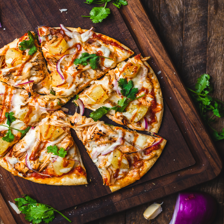

In [22]:
# Code it!
im

## 5. Convert and preprocess the image

Convert the image to a tensor and apply the necessary preprocessing transformations for ResNet50. PyTorch models expect tensors as input, and ResNet50 requires specific normalization values. The original image has three color channels (red, green, blue), and pixel intensity values for each pixel that range from 0 to 255. The normalization gets these values in a better range for the math used in model training.

```python
# Define the preprocessing pipeline for ResNet50
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing to the image
my_image = preprocess(my_image).unsqueeze(0)  # Add batch dimension: Models are set to take in
                                              # a batch of images during training. The unsqueeze
                                              # makes this a "batch" of 1 image.
print(f"Image tensor shape: {my_image.shape}")
my_image
```

In [23]:
# Code it!
# Define the preprocessing pipeline for ResNet50
preproc = transforms.Compose ([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
im = preproc( im ).unsqueeze( 0 )
print(f"Image tensor shape: {im.shape}")
im

Image tensor shape: torch.Size([1, 3, 224, 224])


tensor([[[[-0.6452, -0.7137, -1.0219,  ..., -0.5767, -0.6109, -0.4739],
          [-0.7993, -0.8507, -0.9705,  ..., -0.6452, -0.7479, -0.5596],
          [-0.9020, -0.8678, -0.7650,  ..., -0.7137, -0.8849, -0.6109],
          ...,
          [-0.6109,  0.0398, -0.3198,  ..., -1.6042, -1.6898, -1.4672],
          [-0.3712,  0.2453, -0.2513,  ..., -1.5870, -1.6727, -1.4672],
          [-0.4226,  0.2796,  0.4337,  ..., -1.5699, -1.6384, -1.2445]],

         [[-1.1253, -1.1429, -1.3004,  ..., -0.8627, -0.8803, -0.8277],
          [-1.2304, -1.2479, -1.3004,  ..., -0.9153, -0.9503, -0.8627],
          [-1.3004, -1.2304, -1.1779,  ..., -0.9503, -1.0728, -0.9153],
          ...,
          [-0.9503, -0.3901, -0.7927,  ..., -1.6331, -1.6681, -1.5280],
          [-0.7927, -0.2500, -0.6352,  ..., -1.6155, -1.6506, -1.5280],
          [-0.8277, -0.2150, -0.0574,  ..., -1.5980, -1.6331, -1.4230]],

         [[-0.9678, -0.9678, -1.0376,  ..., -0.8807, -0.9156, -0.8981],
          [-1.0724, -1.0898, -

## 6. Image preprocessing complete

The image has been preprocessed and is now ready for the model. The preprocessing pipeline automatically:
- Resized the image to 224x224 pixels  
- Converted it to a tensor with three color channels (RGB)
- Normalized the pixel values using ImageNet statistics
- Added a batch dimension (1, 3, 224, 224)

In PyTorch, the tensor format is (batch_size, channels, height, width). If our image was gray scale, we would specify one channel instead of three.

This preprocessing ensures the input image matches the format used during ResNet50's training on ImageNet. The normalization values are the channel-wise mean and standard deviation of the ImageNet dataset.

In [24]:
# The preprocessing is already complete - the image is ready for prediction
print(f"Image is ready with shape: {im.shape}")

Image is ready with shape: torch.Size([1, 3, 224, 224])


## 7. Execute prediction

Execute the model's forward pass to get predictions.

```python
# Use the model to predict the class (or category) of the image
with torch.no_grad():  # Disable gradient computation for inference
    my_result = my_model(my_image) 
# View the result
print(f"Output shape: {my_result.shape}")
my_result 
```

In [29]:
# Code it!
# Use the model to predict the class (or category) of the image
with torch.no_grad():
    res = my_model( im )

print(f"out shape: {res.shape}")

out shape: torch.Size([1, 1000])


How could you verify that there are 1,000 numbers in the `my_result` variable?

* Try coding that.
* You may get a clearly incorrect answer. Look closely at how `my_result` printed and see if you can figure out how to get the number of values.
   * Hint, how many square bracket sets are there in `my_result`? 

In [43]:
# Check how many predictions we have
size = res.shape
size.numel()
#len( res[0] )

1000

## 8. Get prediction labels

The model's forward pass returns a tensor with 1,000 numbers (logits). Each number represents the model's confidence that the input image belongs to the corresponding category. The category list is in [this text file](ImageNet_1K_labels.txt).

To convert this to its corresponding text label, we need to apply `softmax` to convert logits to probabilities, then find the class with the highest probability.

The `softmax `converts the outputs of the network to be between 0 and 1, and sum to 1--essentially they are now probabilities for each of the 1,000 categories.


In [34]:
# Apply softmax to convert logits to probabilities
probabilities = torch.nn.functional.softmax(res[0], dim=0)

# Get the top 5 predictions
top5_prob, top5_indices = torch.topk(probabilities, 5)

# Create a list similar to TensorFlow's decode_predictions format
my_label = []
for i in range(5):  # For each fo the top 5 predictions
    class_idx = top5_indices[i].item()  # Get the index
    class_name = imagenet_classes[class_idx]  # Use that index to get the class name
    prob = top5_prob[i].item()  # Get the probability
    my_label.append(
        (class_idx, class_name, prob)
    )  # Add the name and probability to the list

print("Top 5 predictions:")  # Print the resulting list
for i, (idx, name, prob) in enumerate(my_label):
    print(f"{i+1}. {name}: {prob:.4f}")

Top 5 predictions:
1. pizza: 0.9981
2. zucchini: 0.0004
3. frying pan: 0.0002
4. spatula: 0.0001
5. plate: 0.0001


## 9. Assign list item to a variable 

Assign the first item listed by the prediction to a variable - this is the label with the highest probability.

* Extract the label with the highest predicted probability. 
   * The first item in our my_label list contains the prediction with the highest confidence.


In [35]:
top_prediction = my_label[0]
print(f"Top prediction: {top_prediction}")

Top prediction: (963, 'pizza', 0.9980925917625427)


## 10. Print the label 

Include the label in a sentence and then print it.

* The `top_prediction` variable contains information about the prediction in the format (ID, Label, Probability).
* Using `top_prediction[1]` extracts the human-readable label (e.g., 'pizza') for the predicted class.

```python
# Print the predicted class label in a formatted string
print(f"This is an image of a {top_prediction[1]}!") 
```

In [36]:
# Code it!
# Print the predicted class label in a formatted string
print(f"This is an image of a {top_prediction[1]}!")

This is an image of a pizza!


### <img src='images/tip_icon.svg' width=40, align='center' alt='Tip icon'> Tip
> Although we use an image of a pizza here, you can use just about any image with
> this model. Try out this exercise multiple times with different images to see if 
> you can fool it. The [ImageNet_1K_labels.txt](https://raw.githubusercontent.com/PracticumAI/deep_learning/main/Image_Net_1K_labels.txt) 
> file lists all the image categories this model is trained to classify.

## 11. Create a speech sentence

As a busy scientist, Dr. Amelia tries to multi-task as much as possible. Now that she has the image recognition step worked out, she wants to add an audio component to her program to read the results while working out at the gym.

Luckily, text-to-speech technology is as easy to implement as image recognition! Let's help Amelia get the next step of her prototype up and running!

Create a longer sentence to convert to speech. 
```python
say_it = f"This participant is eating {top_prediction[1]} today."
```

In [37]:
# Code it!
say_it = f"This participant is eating {top_prediction[1]} today."

## 12. Execute the gtts function

Pass the say_it variable to the gTTS API.

```python
my_speech = gTTS(text = say_it)
```

In [38]:
# Code it!
my_speech = gTTS(text = say_it)

## 13. Save the audio file

gTTS will convert the string you gave it into an audio file. Save the audio file. The default location is the current directory.

```python
# Save the audio file in the current directory.
my_speech.save("prediction.mp3") 
```

In [ ]:
# Code it!
my_speech.save("prediction.mp3")

## 14. Let's put it all together

We can put all of these steps together in a function to make it easier to test more images.

In [ ]:
def what_are_they_eating(image_path):
    """Takes an image path and returns a ResNet50 prediction using PyTorch."""
    # Load and preprocess the image
    my_image = Image.open(image_path)

    # Define preprocessing
    preprocess = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Apply preprocessing and make it a batch
    my_image = preprocess(my_image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        my_result = my_model(my_image)

    # Convert to probabilities and get top prediction
    probabilities = torch.nn.functional.softmax(my_result[0], dim=0)
    top_prob, top_idx = torch.topk(probabilities, 1)

    class_idx = top_idx[0].item()
    class_name = imagenet_classes[class_idx]
    prob = top_prob[0].item()

    return (class_idx, class_name, prob)


def tell_me_what_they_ate(label):
    """Takes a label and returns a mp3 speech file with the item that was eaten."""
    say_it = f"This participant is eating {label} today."
    my_speech = gTTS(text=say_it)
    my_speech.save(f"{label}_prediction.mp3")
    print(f"Sound file saved to {label}_prediction.mp3")

In [ ]:
# Now run on a new image of pizza
# Image courtesy of Ruslan Khmelevsky https://www.pexels.com/photo/a-pizza-inside-the-brick-oven-14129177/
label = what_are_they_eating("images/hawaiian_pizza_khmelevsky.jpg")
print(label)

tell_me_what_they_ate(label[1])

## 16. Test other items
Amelia should also test with some other food items to ensure her system is working. Let's try this burger.

![Photo of a hamburger](images/hamburger.jpg)

In [ ]:
label = what_are_they_eating("images/hamburger.jpg")
print(label)

tell_me_what_they_ate(label[1])

#### How did that work?
 
Amelia's classifier works well, predicting that the image is a cheeseburger. But...I don't see any cheese on that burger! Why do you think the cheeseburger category was selected? Remember to look at the [ImageNet categories](ImageNet_1K_labels.txt). 

Remember, a model will output probabilities of the categories it was trained on, and all the output probabilities must sum to one. The model has no mechanism to tell you it doesn't recognize the image!


## 17. More challenges

Hmm...While reviewing some predictions, Amelia discovers a problem. Did the participant eat pizza again? or is this a quiche?

![A photo of quiche](images/quiche.jpg)

In [ ]:
label = what_are_they_eating("images/quiche.jpg")
print(label)

tell_me_what_they_ate(label[1])

Again, consider the importance of training data representing the data used when the model is deployed. Recognize the limitations of models to make predictions based on the training categories. 

These issues relate to the discussion of AI ethics and how well your AI model will work. If the training data do not represent the data used in deployment, AI models will be of limited value and can even be misleading. The consequences may be manageable for Amelia's research study, but we must carefully evaluate the performance and suitability of all AI models as we work with them.

Hopefully, this fun exercise showed how easy it can be to use AI models to accomplish everyday tasks like image classification and text-to-speech. 

### Further refinement

As we have helped Dr. Amelia discover, she may be unable to use ResNet50 trained on ImageNet for her task. There are too few food categories to work reliably for her study. Does that mean she needs to start from scratch?

No! In  *Practicum AI* **Transfer Learning** course, you can learn how transfer learning allows you to take a model trained on one dataset and fine-tune it for a new dataset. With transfer learning, you can harness the information a model has learned about its training data, 1,000 categories of objects in the case of ImageNet, and add new information specific to your task. The advantage here is that you typically need far less data to train a model to recognize many food types, for example, when it already knows about food and many other things in the world!


Please tune in to our next notebook to see what Amelia is up to next!


## Bonus Exercises

1. Change the code so that if the confidence of the model's prediction is less than 0.75, the code output says it's not sure what the image is.
1. Change the code to output the top *n* categories and their probabilities.
1. Change the code so that each loaded image has its label added to a list saved to a text file.


## Before continuing
###  <img src='images/alert_icon.svg' alt="Alert icon" width=40 align=center> Alert!
> Before continuing to another notebook within the same Jupyter session,
> use the **"Running Terminals and Kernels" tab** (below the File Browser tab) to **shut down this kernel**. 
> This will free up this notebook's GPU memory, making it available for
> your next notebook.
>
> Every time you run multiple notebooks within a Jupyter session with a GPU, this should be done.
>
> ![Screenshot of the Running Terminals and Kernels tab used t oshut down kernels before starting a new notebook](images/stop_kernel.png)

----
## Push changes to GitHub <img src="images/push_to_github.png" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.
